# Ising model Monte-Carlo with Metropolis Checkerboard update on Tensorflow

## Imports

In [2]:
import numpy as np
import tensorflow as tf #(v1.12)
%matplotlib notebook
import matplotlib.pyplot as plt

## Ising Model simulation parameters

In [3]:
tf.reset_default_graph()
print_shape = True 
MCS_total = 10000
MCS_measure = 100
dims = 2
BOUNDARY_CONDITION = 1
uniformJ = tf.placeholder(tf.float32)
uniformH = tf.placeholder(tf.float32)
Temperature = tf.placeholder(tf.float32)

In [4]:
latticesize = tuple([1000]*dims)
spin_input = tf.placeholder(tf.float32,latticesize)

## Boundary Condition

In [5]:
def shift_spin(x,dim=0,shift=0,bc=1):    
    shifted_x = x
    if shift==1:
        perm = np.arange(dims)
        perm[0] = dim
        perm[dim]= 0
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([shifted_x[1:],bc*shifted_x[:1]],axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    if shift==-1:
        perm = np.arange(dims)
        perm[0] = dim
        perm[dim]= 0
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([bc*shifted_x[-1:],shifted_x[:-1]],axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    return shifted_x
# shift_spin(spin_input)

## Checkerboard update

In [16]:
def potential_persite(x,print_shape=False):
    potential = -uniformH+0*shift_spin(x,dim=0,shift=0,bc=BOUNDARY_CONDITION)
    for d in range(dims):
        for s in [-1,1]:
            potential = potential - uniformJ*shift_spin(x,dim=d,shift=s,bc=BOUNDARY_CONDITION)

    if print_shape: print("potential:"+str(potential.shape))
    return potential

In [17]:
stencil = spin_input*0
for d in range(dims):
    stencil = tf.mod(stencil + tf.cumsum(spin_input*0+1,axis=d),2)
if print_shape: print("stencil:"+str(stencil.shape))

stencil:(1000, 1000)


In [18]:
def update(x,stenc,seed=(0,1)):
    r = tf.random.uniform(latticesize, minval=0, maxval=1, dtype=tf.float32)
    dE = -2*x*stenc*potential_persite(x)
    p = tf.where(dE<=0.0,stenc,stenc*tf.exp(-dE/Temperature))
    y = tf.where(p>1-r,-x,x)
    return y
# update(spin_input,stencil)

In [19]:
def measure_step(x):
    spinin = [x]
    for i in range(MCS_measure):
        y = update(spinin[-1],stencil)
        spinin.append(update(y,1-stencil))
    return spinin

In [20]:
%%time
spin_output = measure_step(spin_input)

CPU times: user 9.63 s, sys: 183 ms, total: 9.81 s
Wall time: 9.83 s


In [21]:
try:
    sess.close()
    print("Closing previous open session")
except NameError:
    print("No previous session open")
    
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


No previous session open


# Simulate

<IPython.core.display.Javascript object>


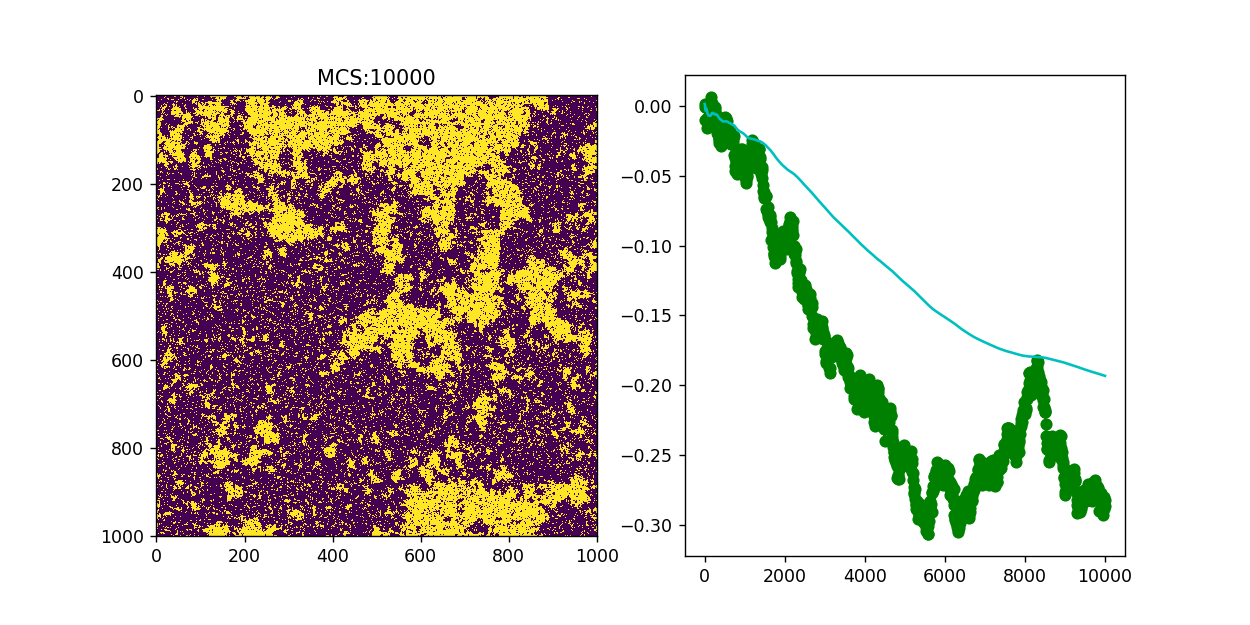

MCS:10000  Done!
CPU times: user 5min 7s, sys: 7.7 s, total: 5min 15s
Wall time: 3min 5s


In [28]:
%%time
import time
# t_start = time.time()
spin = np.random.randint(0,2,size=latticesize)*2-1
fig,ax = plt.subplots(1,2,figsize=(10,5))
plt.ion()

magi = []
cumagi = []
stepi = []
MCS_stepsize = 10
# print(tim.time()-t_start,"seconds")
for i in range(MCS_total//MCS_stepsize):
    ax[0].cla()
    ax[1].cla()
    
    ax[0].set_title("MCS:"+str(MCS_stepsize*i))
    ax[0].imshow(spin,vmin=-1,vmax=1)
    magi.append(np.mean(spin))
    cumagi.append(np.mean(magi))
    stepi.append(MCS_stepsize*i)
    ax[1].plot(stepi,magi,c='g',marker='o')
    ax[1].plot(stepi,cumagi,c='c')
    fig.canvas.draw()
    plt.pause(0.0001)
    spin = spin_output[MCS_stepsize].eval(feed_dict={spin_input:spin, Temperature: 2.27, uniformJ: 1.0, uniformH: 0.0})
    print("\r"+"MCS:"+str(MCS_stepsize*i),end='  ',flush=True)
i+=1
print("\r"+"MCS:"+str(MCS_stepsize*i),end='  Done!\n',flush=True)
ax[0].cla()
ax[1].cla()
ax[0].set_title("MCS:"+str(MCS_stepsize*i))
ax[0].imshow(spin,vmin=-1,vmax=1)
magi.append(np.mean(spin))
cumagi.append(np.mean(magi))
stepi.append(MCS_stepsize*i)
ax[1].plot(stepi,magi,c='g',marker='o')
ax[1].plot(stepi,cumagi,c='c')
fig.canvas.draw()
plt.pause(0.0001)